# Approximating Steel Cased Wells - DC

[Lindsey Heagy](http://github.com/lheagy)

In this example, we examine the impact of upscaling the well using
- the assumption that the well is a solid rod of steel
- averaging conductivity such that the $\sigma A$ is the same in both cases

This notebook was used to produce Figures 22, 23 in Heagy & Oldenburg, 2018

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

In [2]:
simDir = 'DC_approximations'  # create a simulation directory where results can be saved. 

In [3]:
casing_l = [250, 500, 1000, 2000, 4000]
sigma_back = 1e-1

In [4]:
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

def get_model(casing_length):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_casing = 5e6,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        sigma_air = 3e-7,   # conductivity of the air
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_length,
        casing_t = casing_t, 
        src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
        src_b = np.r_[8000, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
    )

    # adjust the src_a location so it is connected to well
    model.src_a = np.r_[model.casing_r, np.pi, -1.25]  
    return model

In [5]:
model_names = ["casing_{:1.0f}".format(l) for l in casing_l]
model_dict = {"casing_{:1.0f}".format(l):get_model(l) for l in casing_l}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [6]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 20.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 500  # go out 500m from the well

# padding parameters
npadx, npadz = 16, 20  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
ncy = 1
# ncy = 12
# nstretchy = 5
# stretchfact = 1.5
# hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = np.ones(ncy)
hy = hy * 2*np.pi/hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry

def get_mesh(mod):
    cylMeshGen = casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
        hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )
    return cylMeshGen

In [7]:
mesh_dict = {"{:1.0f}".format(l): get_mesh(model_dict["casing_{:1.0f}".format(l)]) for l in casing_l}

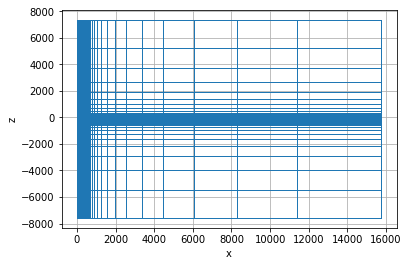

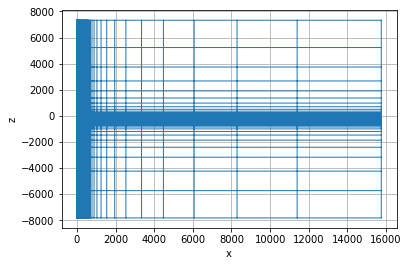

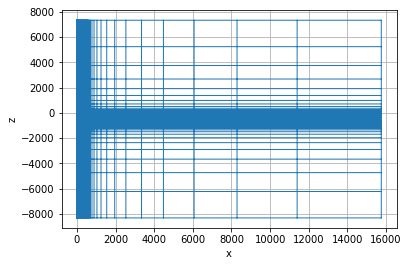

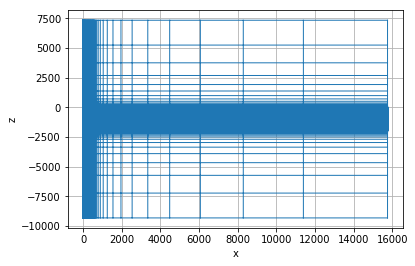

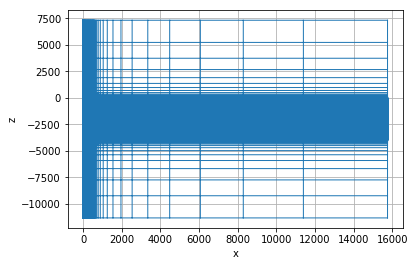

In [8]:
for mesh in mesh_dict.values():
    mesh.mesh.plotGrid()

In [9]:
# src_theta = np.pi + hy[0]/2

# model.src_a[1] = src_theta
# model.src_b[1] = src_theta

# for m in modelDict.values():
#     m.src_a[1] = src_theta
#     m.src_b[1] = src_theta

## Create models to compare to

Here, we create two more models which we want to simulate on
- `solid` fills in the center of the casing with a conductivity equal to that of steel
- `sigma_A` approximates the casing as a solid rod with conductivity found by preserving the conductivity - cross sectional area product. 

In [10]:
model_names

['casing_250', 'casing_500', 'casing_1000', 'casing_2000', 'casing_4000']

In [11]:
# Solid steel
def get_cylinder_model(model, option='solid'):
    model_solid = model.copy()
    model_solid.casing_d = casing_d / 2.
    model_solid.casing_t = casing_d / 2.
    model_solid.sigma_inside = model_solid.sigma_casing  # fill in the center of the well with steel
    
    if option == 'sigmaA':
        sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2) / (model.casing_b**2)  # times pi / pi
        model_solid.sigma_inside = sigmaA
        model_solid.sigma_casing = sigmaA
    return model_solid

In [12]:
model_dict.update(
    {"solid_{:1.0f}".format(l): get_cylinder_model(model_dict["casing_{:1.0f}".format(l)], 'solid') for l in casing_l}
)

model_dict.update(
    {"sigma_A_{:1.0f}".format(l): get_cylinder_model(model_dict["casing_{:1.0f}".format(l)], 'sigmaA') for l in casing_l}
)

In [13]:
model_names = ["{}".format(key) for key in model_dict.keys()]

In [14]:
# Assign physical properties on the mesh
physprops_dict = {
    key: casingSim.model.PhysicalProperties(mesh_dict[key.split("_")[-1]], model_dict[key]) for key in model_names
}

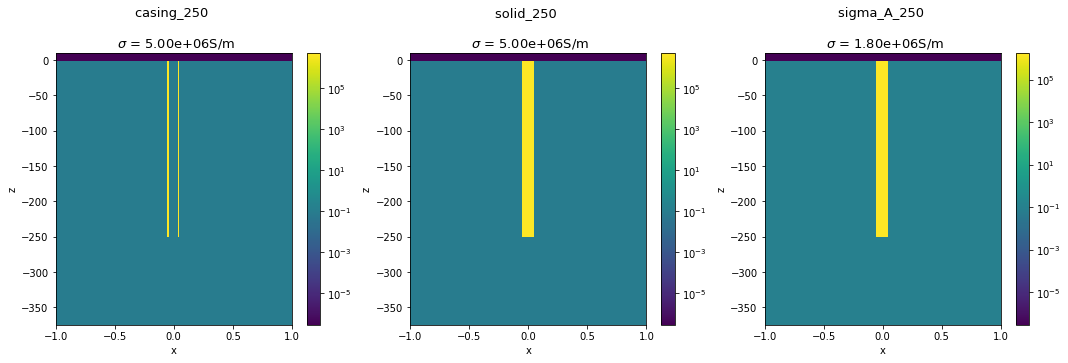

In [15]:
l = casing_l[0]

# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*l, 10.]  # z-limits in meters. (z-positive up)


fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for a, model_key in zip(ax, ["casing", "solid", "sigma_A"]):
    key = "{}_{:1.0f}".format(model_key, l)
    pp = physprops_dict[key]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(key, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [16]:
# # Set up 1 source: top casing

src_a = np.r_[model_dict[model_names[0]].casing_r, np.pi, -1.25]
src_b = np.r_[8000, np.pi, -1.25]

## set up a DC simulation

In [17]:
sim_dict = {}
for key in model_names:
#     print(mesh_dict[key.split("_")[-1]])
    sim_dict[key] = casingSim.run.SimulationDC(
        modelParameters=model_dict[key], directory=simDir, 
        meshGenerator=mesh_dict[key.split("_")[-1]], 
        src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this

## Run the simulation

In [18]:
%%time
fields_dict = {}
for key in model_names:
    print('--- Running {} ---'.format(key))
    fields_dict[key] = sim_dict[key].run()
    print('\n')

--- Running casing_250 ---
Validating parameters...
      max x: 15755.673364665585, min z: -7574.722349712412, max z: 7324.722349712409, nC: 14550
Saved DC_approximations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.1031498908996582


--- Running casing_500 ---
Validating parameters...
      max x: 15755.673364665585, min z: -7824.722349712412, max z: 7324.722349712409, nC: 24250
Saved DC_approximations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.15205121040344238


--- Running casing_1000 ---
Validating parameters...
      max x: 15755.673364665585, min z: -8324.722349712412, max z: 7324.722349712405, nC: 43650
Saved DC_approximations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.24474811553955078


--- Running casing_2000 ---
Validating p

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [19]:
src_ind=0

def plot_results(ax=None):
    """
    Plot the currents and charges along the length of the casing. If `include_transmission`
    is True, then the transmission line solutions from Kaufmann (described in the functions 
    above) are included
    """
   
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(10, 4)) #, dpi=400)
    
    for i, key in enumerate(model_names):
        f = fields_dict[key]
        src = sim_dict[key].survey.srcList[src_ind]
        mod = model_dict[key]
        mesh = mesh_dict[key.split("_")[-1]].mesh
    
        z_currents, iz = casingSim.casing_currents(f[src, 'j'], mesh, mod)["z"]
        z_charges, charges = casingSim.casing_charges(f[src, 'charge'], mesh, mod)
        
        
        
        label = key.split("_")[-1] + " m"
        
        ax[0, 0].plot(-z_currents/mod.casing_l, -iz, label=label, color="C{}".format(i))
        ax[1, 0].plot(-z_charges/mod.casing_l, charges, label=label, color="C{}".format(i))
        
        casingSim.view.plotLinesFx(
            mesh, field=f[src,'e'],
            pltType='semilogy', ax=ax[2, 0],
            theta_ind=theta_ind, xlim=xlim, 
            color_ind=i, label=key, 
            zloc=zloc
        )
        

    [a.set_xlim([1.25/mod.casing_l, 1.]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('depth / casing length') for a in ax]
    [a.grid(which='both', alpha=0.4) for a in ax]

    ax[0].set_ylabel('downward-going current (A)')
    ax[1].set_ylabel('charge (C)')
    
    return ax

In [20]:
def get_surface_efield(key, zloc=0, src_ind=0, xlim=np.r_[0, np.inf]):
    mesh2D = mesh_dict[key.split("_")[-1]].mesh
    src = sim_dict[key].survey.srcList[src_ind]
    fplt = fields_dict[key][src, 'e']

    fx = discretize.utils.mkvc(fplt[:mesh2D.vnF[0]].reshape(
        [mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
    )
    xind = ((mesh2D.gridFx[:, 0] > xlim[0]) & (mesh2D.gridFx[:, 0] < xlim[1]))
    zind = (
        (mesh2D.gridFx[:, 2] > -mesh2D.hz.min()+zloc) & (mesh2D.gridFx[:, 2] < zloc)
    )
    pltind = xind & zind
    
    x = mesh2D.gridFx[pltind, 0]
    e = fx[pltind]
    
    return x, e

In [21]:
import matplotlib.lines as mlines
from string import ascii_lowercase 
from matplotlib import rcParams
rcParams['font.size'] = 12

### Plot the currents and charges

solid_250: 1.47e-02, 2.89e-14
sigma_A_250: 6.13e-06, 2.96e-17
solid_500: 4.74e-02, 4.92e-14
sigma_A_500: 2.78e-06, 1.27e-17
solid_1000: 1.19e-01, 7.22e-14
sigma_A_1000: 8.99e-07, 3.93e-18
solid_2000: 1.80e-01, 8.39e-14
sigma_A_2000: 6.29e-07, 5.43e-19


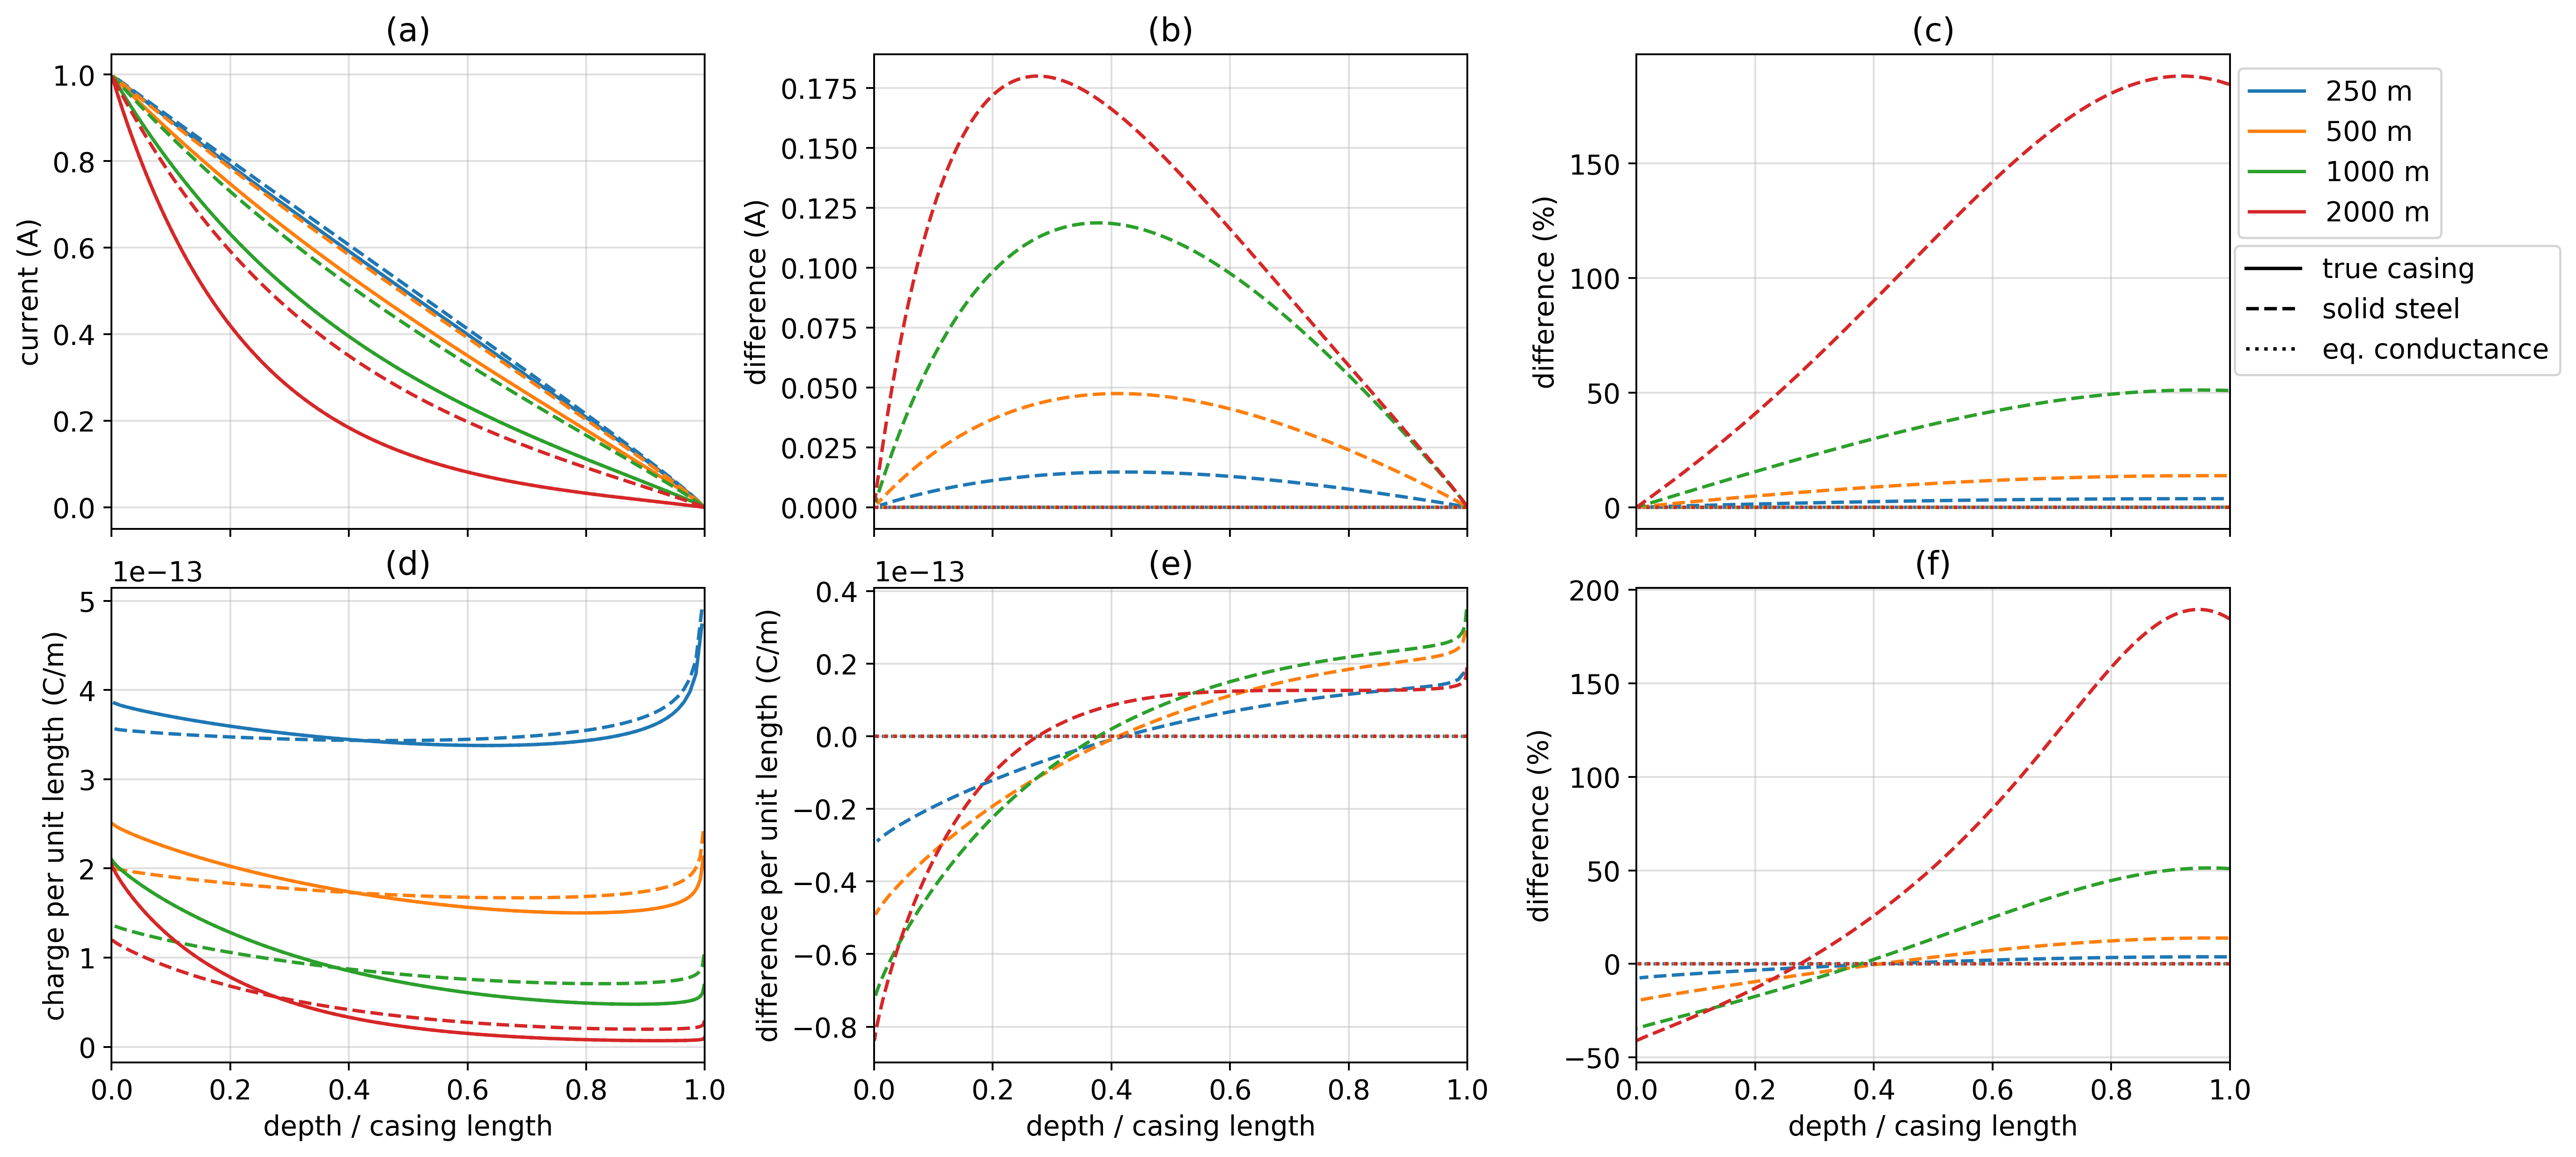

In [22]:
fig, ax  =  plt.subplots(2, 3, figsize=(14, 7), dpi=350)

for i, l in enumerate(casing_l[:-1]):
    
    mesh = mesh_dict["{}".format(l)].mesh
    
    src = sim_dict["casing_{}".format(l)].survey.srcList[src_ind]
    _, iz_casing = casingSim.casing_currents(
        fields_dict["casing_{}".format(l)][src, 'j'], mesh, model_dict["casing_{}".format(l)]
    )["z"]
    _, charges_casing = casingSim.casing_charges(
        fields_dict["casing_{}".format(l)][src, 'charge'], mesh, model_dict["casing_{}".format(l)]
    )

    for model_key, ls in zip(["casing", "solid", "sigma_A"], ["-", "--", ":"]):
        key = "{}_{}".format(model_key, l)
        f = fields_dict[key]
        src = sim_dict[key].survey.srcList[src_ind]
        mod = model_dict[key]

        z_currents, iz = casingSim.casing_currents(f[src, 'j'], mesh, mod)["z"]
        z_charges, charges = casingSim.casing_charges(f[src, 'charge'], mesh, mod)

        label = key.split("_")[-1] + " m"

        ax[0, 0].plot(
            -z_currents/mod.casing_l, -iz, label=label if ls == "-" else None, color="C{}".format(i), 
            ls=ls
        )
        ax[1, 0].plot(-z_charges/mod.casing_l, charges / csz, color="C{}".format(i), ls=ls)
        
        if model_key != "casing":
            diff_i = (iz - iz_casing)
            diff_charges = (charges - charges_casing) / csz
            print("{}: {:1.2e}, {:1.2e}".format(key, np.absolute(diff_i).max(), np.absolute(diff_charges).max()))
        
            ax[0, 1].plot(
                -z_currents/mod.casing_l, -(diff_i), label=label if ls == "-" else None, color="C{}".format(i), 
                ls=ls
            )
            ax[1, 1].plot(-z_charges/mod.casing_l, diff_charges, color="C{}".format(i), ls=ls)
            
            ax[0, 2].plot(
                -z_currents/mod.casing_l, -(iz - iz_casing) / np.abs(iz_casing) * 100, label=label if ls == "-" else None, color="C{}".format(i), 
                ls=ls
            )
            ax[1, 2].plot(-z_charges/mod.casing_l, (charges - charges_casing) / np.abs(charges_casing) * 100, color="C{}".format(i), ls=ls)
        

[a.set_xlim([0., 1.]) for a in ax.flatten()]
# [a.legend() for a in ax]
# [a.set_xlabel('depth / casing length') for a in ax]
[a.grid(which='both', alpha=0.4) for a in ax.flatten()]

ax[0, 0].set_ylabel('current (A)')
ax[0, 1].set_ylabel('difference (A)')
ax[0, 2].set_ylabel('difference (%)')

ax[1, 0].set_ylabel('charge per unit length (C/m)')
ax[1, 1].set_ylabel('difference per unit length (C/m)')
ax[1, 2].set_ylabel('difference (%)')

for a in ax[0, :]:
    a.set_xticklabels(['']*len(a.get_xticklabels()))
    a.set_xlabel('')

for a in ax[1, :]:
    a.set_xlabel("depth / casing length")
    
plt.tight_layout()


ax[0, 0].legend(bbox_to_anchor=[3.95, 1])

ax[1, 0].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='true casing'),
        mlines.Line2D([], [], color='k', linestyle='--', label='solid steel'), 
        mlines.Line2D([], [], color='k', linestyle=':', label='eq. conductance')
    ], bbox_to_anchor=[4.15, 1.75]
)
# [a.ticklabel_format(scilimits=(0, 3)) for a in ax[1, :]]
# [a.update_ticks() for a in ax[1, :]]
[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

# ax[0].set_ylabel('downward-going current (A)')
# ax[1].set_ylabel('charge (C)')

# ax[1].set_ylim(8e-12*np.r_[0, 1])
# # [a.set_xlim([-mod.src_a[2]/mod.casing_l, 1.]) for a in ax]

# ax[0].set_title('(a)')
# ax[1].set_title('(b)')
fig.savefig("../figures/approximating_wells_currents_charges", bbox_inches="tight", dpi=350)
fig.savefig("../arxiv-figures/approximating_wells_currents_charges", bbox_inches="tight", dpi=150)


In [23]:
def conduction_length(sigma_casing, casing_diameter, casing_thickness, sigma_back):
    a = casing_diameter / 2.
    delta_a = casing_thickness
    Sc = 4*np.pi*a*delta_a*sigma_casing
    return np.sqrt(Sc/sigma_back)

In [24]:
# parameters from Um et al., 2015 
conduction_length(1e6, 135e-3, 12.223e-3, 0.033)

560.5169554190395

### Plot the radial electric field at the surface

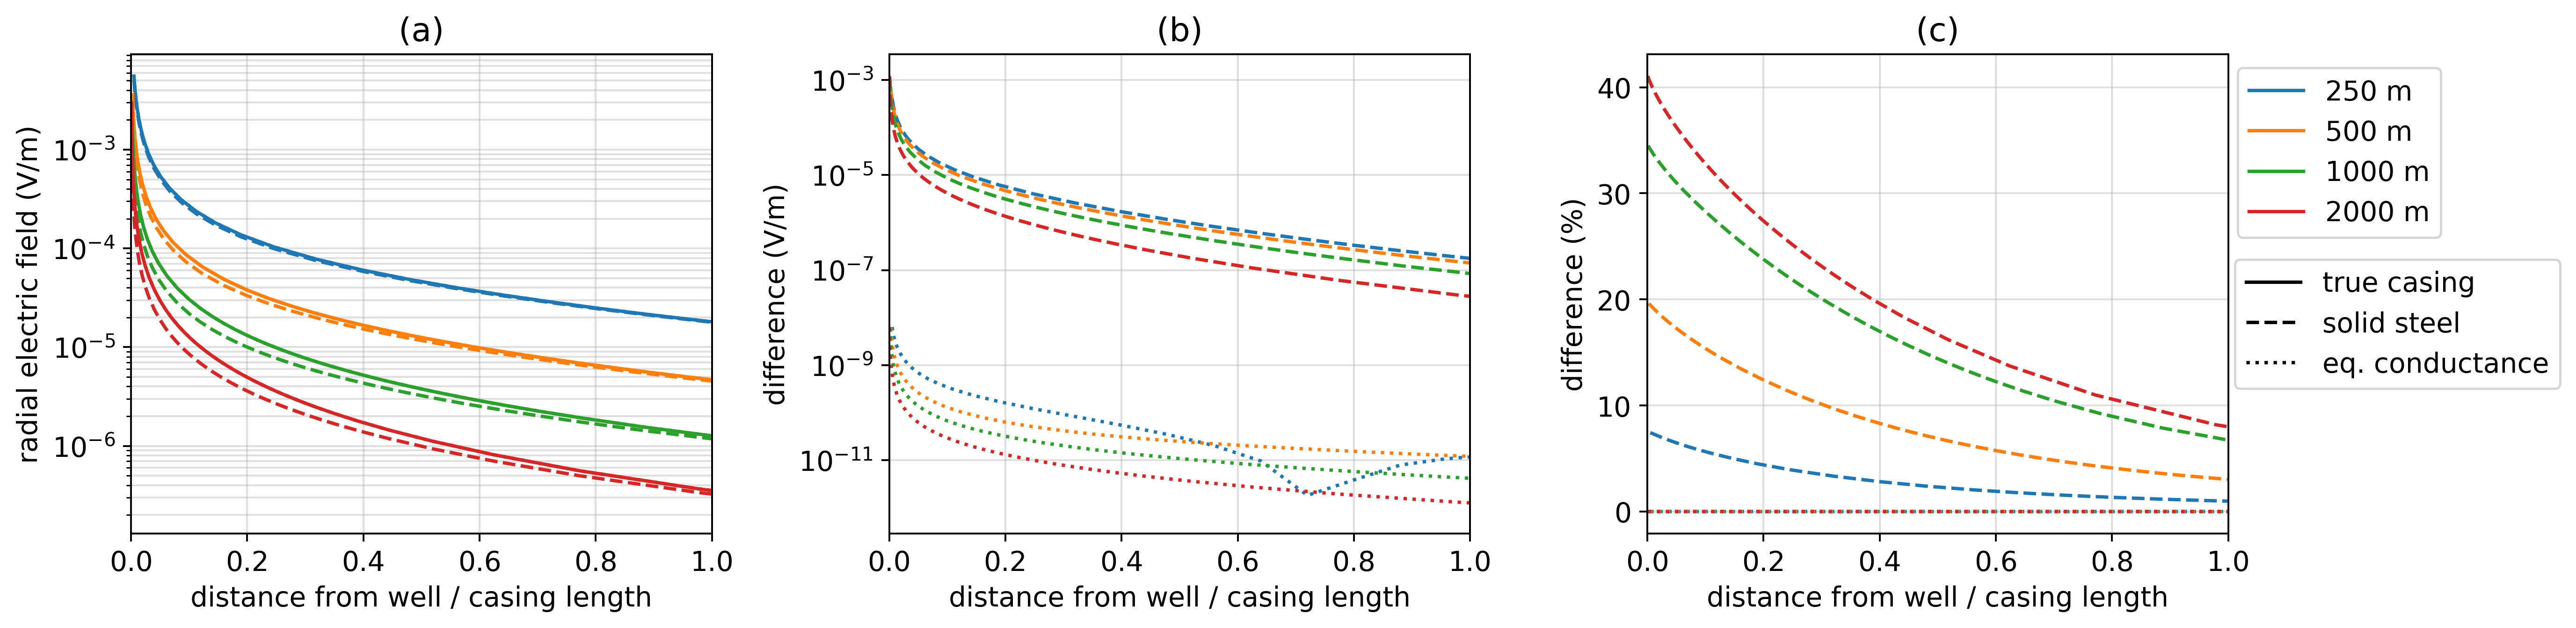

In [25]:
fig, ax = plt.subplots(1, 3, figsize= (14, 4), dpi=350)

for i, l in enumerate(casing_l[:-1]):
    
    mesh = mesh_dict["{}".format(l)].mesh
    
    src = sim_dict["casing_{}".format(l)].survey.srcList[src_ind]
    _, e_field_casing = get_surface_efield("casing_{}".format(l), xlim=[1., l*1.5])

    for model_key, ls in zip(["casing", "solid", "sigma_A"], ["-", "--", ":"]):
        key = "{}_{}".format(model_key, l)
        f = fields_dict[key]
        src = sim_dict[key].survey.srcList[src_ind]
        mod = model_dict[key]

        x, e_field = get_surface_efield(key, xlim=[1., l*1.5])

        label = key.split("_")[-1] + " m"

        ax[0].semilogy(x/mod.casing_l, e_field, color="C{}".format(i), ls=ls, label=label if ls=='-' else None)
        
        if model_key != "casing":
    
            ax[1].semilogy(x/mod.casing_l, np.abs(e_field - e_field_casing), color="C{}".format(i), ls=ls)
            ax[2].plot(x/mod.casing_l, np.abs(e_field - e_field_casing) / np.abs(e_field_casing) * 100, color="C{}".format(i), ls=ls)
        

[a.set_xlim([0., 1.]) for a in ax.flatten()]
ax[0].legend()
# [a.legend() for a in ax]
[a.set_xlabel('distance from well / casing length') for a in ax]
[a.grid(which='both', alpha=0.4) for a in ax.flatten()]
[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax)]

ax[0].set_ylabel('radial electric field (V/m)')
ax[1].set_ylabel('difference (V/m)')
ax[2].set_ylabel('difference (%)')
plt.tight_layout()

ax[0].legend(bbox_to_anchor=[4, 1])

ax[1].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='true casing'),
        mlines.Line2D([], [], color='k', linestyle='--', label='solid steel'), 
        mlines.Line2D([], [], color='k', linestyle=':', label='eq. conductance')
    ], bbox_to_anchor=[2.9, 0.6]
)
# ax[0].set_ylabel('downward-going current (A)')
# ax[1].set_ylabel('charge (C)')

# ax[1].set_ylim(8e-12*np.r_[0, 1])
# # [a.set_xlim([-mod.src_a[2]/mod.casing_l, 1.]) for a in ax]




fig.savefig('../figures/approximating_wells_electric_fields', bbox_inches="tight", dpi=350)
fig.savefig("../arxiv-figures/approximating_wells_electric_fields", bbox_inches="tight", dpi=150)

